In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore")

# Setup Plotting Style to match team
plt.style.use('seaborn-v0_8-darkgrid')

# Check GPU
print(f"TensorFlow Version: {tf.__version__}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is ready!")
else:
    print("Running on CPU")

# Create output directory
MODEL_DIR = "Universal_LSTM_Results"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

TensorFlow Version: 2.19.0
GPU is ready!


In [2]:
# 1. Load Data
print("Loading FULL dataset...")
df = pd.read_csv('final_training_data_all_regions.csv')
df['time'] = pd.to_datetime(df['time'])

# Sort by Region + Time (Crucial for sequence generation)
df = df.sort_values(by=['region', 'time'])

# 2. Feature Engineering
# Add Time Cycles
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)

# One-Hot Encode Regions
df_encoded = pd.get_dummies(df, columns=['region'], prefix='city')

# 3. Define Features
target_col = 'pm2_5 (μg/m³)'

# Select features
feature_cols = [
    'temperature_2m (°C)', 'relative_humidity_2m (%)',
    'wind_speed_10m (km/h)', 'wind_direction_10m (°)',
    'nitrogen_dioxide (μg/m³)', 'dust (μg/m³)',
    'aerosol_optical_depth ()',
    'hour_sin', 'hour_cos'
]
city_cols = [col for col in df_encoded.columns if col.startswith('city_')]
all_features = feature_cols + city_cols

print(f"Features Selected: {len(all_features)}")
print(f"Cities included: {city_cols}")

# 4. Scaling
scaler_X = MinMaxScaler()
X_data = scaler_X.fit_transform(df_encoded[all_features])

scaler_y = MinMaxScaler()
y_data = scaler_y.fit_transform(df_encoded[[target_col]])

print(f"Total Rows: {len(df)}")

Loading FULL dataset...
Features Selected: 15
Cities included: ['city_doha', 'city_khor', 'city_qatar', 'city_rayyan', 'city_ummsalal', 'city_wakrah']
Total Rows: 129540


In [3]:
def create_sequences(data_df, x_scaled, y_scaled, time_steps=48):
    Xs, ys = [], []
    # We use the original dataframe 'data_df' to get the group indices
    # but append data from the scaled arrays to ensure we don't mix regions
    for region_name, group in data_df.groupby('region'):
        indices = group.index

        region_X = x_scaled[indices]
        region_y = y_scaled[indices]

        for i in range(len(region_X) - time_steps):
            Xs.append(region_X[i:(i + time_steps)])
            ys.append(region_y[i + time_steps])

    return np.array(Xs), np.array(ys)

TIME_STEPS = 48
print("Creating sequences (this may take a minute)...")
X_seq, y_seq = create_sequences(df, X_data, y_data, TIME_STEPS)

print(f"Final Input Shape: {X_seq.shape}")

# Split Train/Test (95% Train, 5% Test as requested)
split = int(len(X_seq) * 0.95)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

Creating sequences (this may take a minute)...
Final Input Shape: (129251, 48, 15)
Train samples: 122788 | Test samples: 6463


In [4]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # Bidirectional LSTM (Your architecture)
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.Huber(),
              metrics=['mae', 'mse'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

print("Training Universal Model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save model
model.save(os.path.join(MODEL_DIR, 'universal_lstm_model.keras'))
print("Model saved.")

Training Universal Model...
Epoch 1/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 0.0027 - mae: 0.0522 - mse: 0.0055 - val_loss: 0.0017 - val_mae: 0.0453 - val_mse: 0.0034 - learning_rate: 0.0010
Epoch 2/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0018 - mae: 0.0415 - mse: 0.0035 - val_loss: 0.0013 - val_mae: 0.0374 - val_mse: 0.0025 - learning_rate: 0.0010
Epoch 3/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.0015 - mae: 0.0393 - mse: 0.0031 - val_loss: 0.0012 - val_mae: 0.0358 - val_mse: 0.0023 - learning_rate: 0.0010
Epoch 4/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0014 - mae: 0.0372 - mse: 0.0027 - val_loss: 9.9824e-04 - val_mae: 0.0335 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 5/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.0013 - mae: 0.0360 - mse: 0.0025 - val_loss: 9.6303e-04 - val_mae: 0.0323 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 6/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0011 - mae: 0.0338 -

Generating predictions...
--------------------------------------------------

Test Set Metrics:
  MAE: 2.91 μg/m³
  RMSE: 3.81 μg/m³
  R² Score: 0.9366
  MAPE (Inv Accuracy): 9.29%
  *Precision/Recall are for classification and do not apply here.
--------------------------------------------------


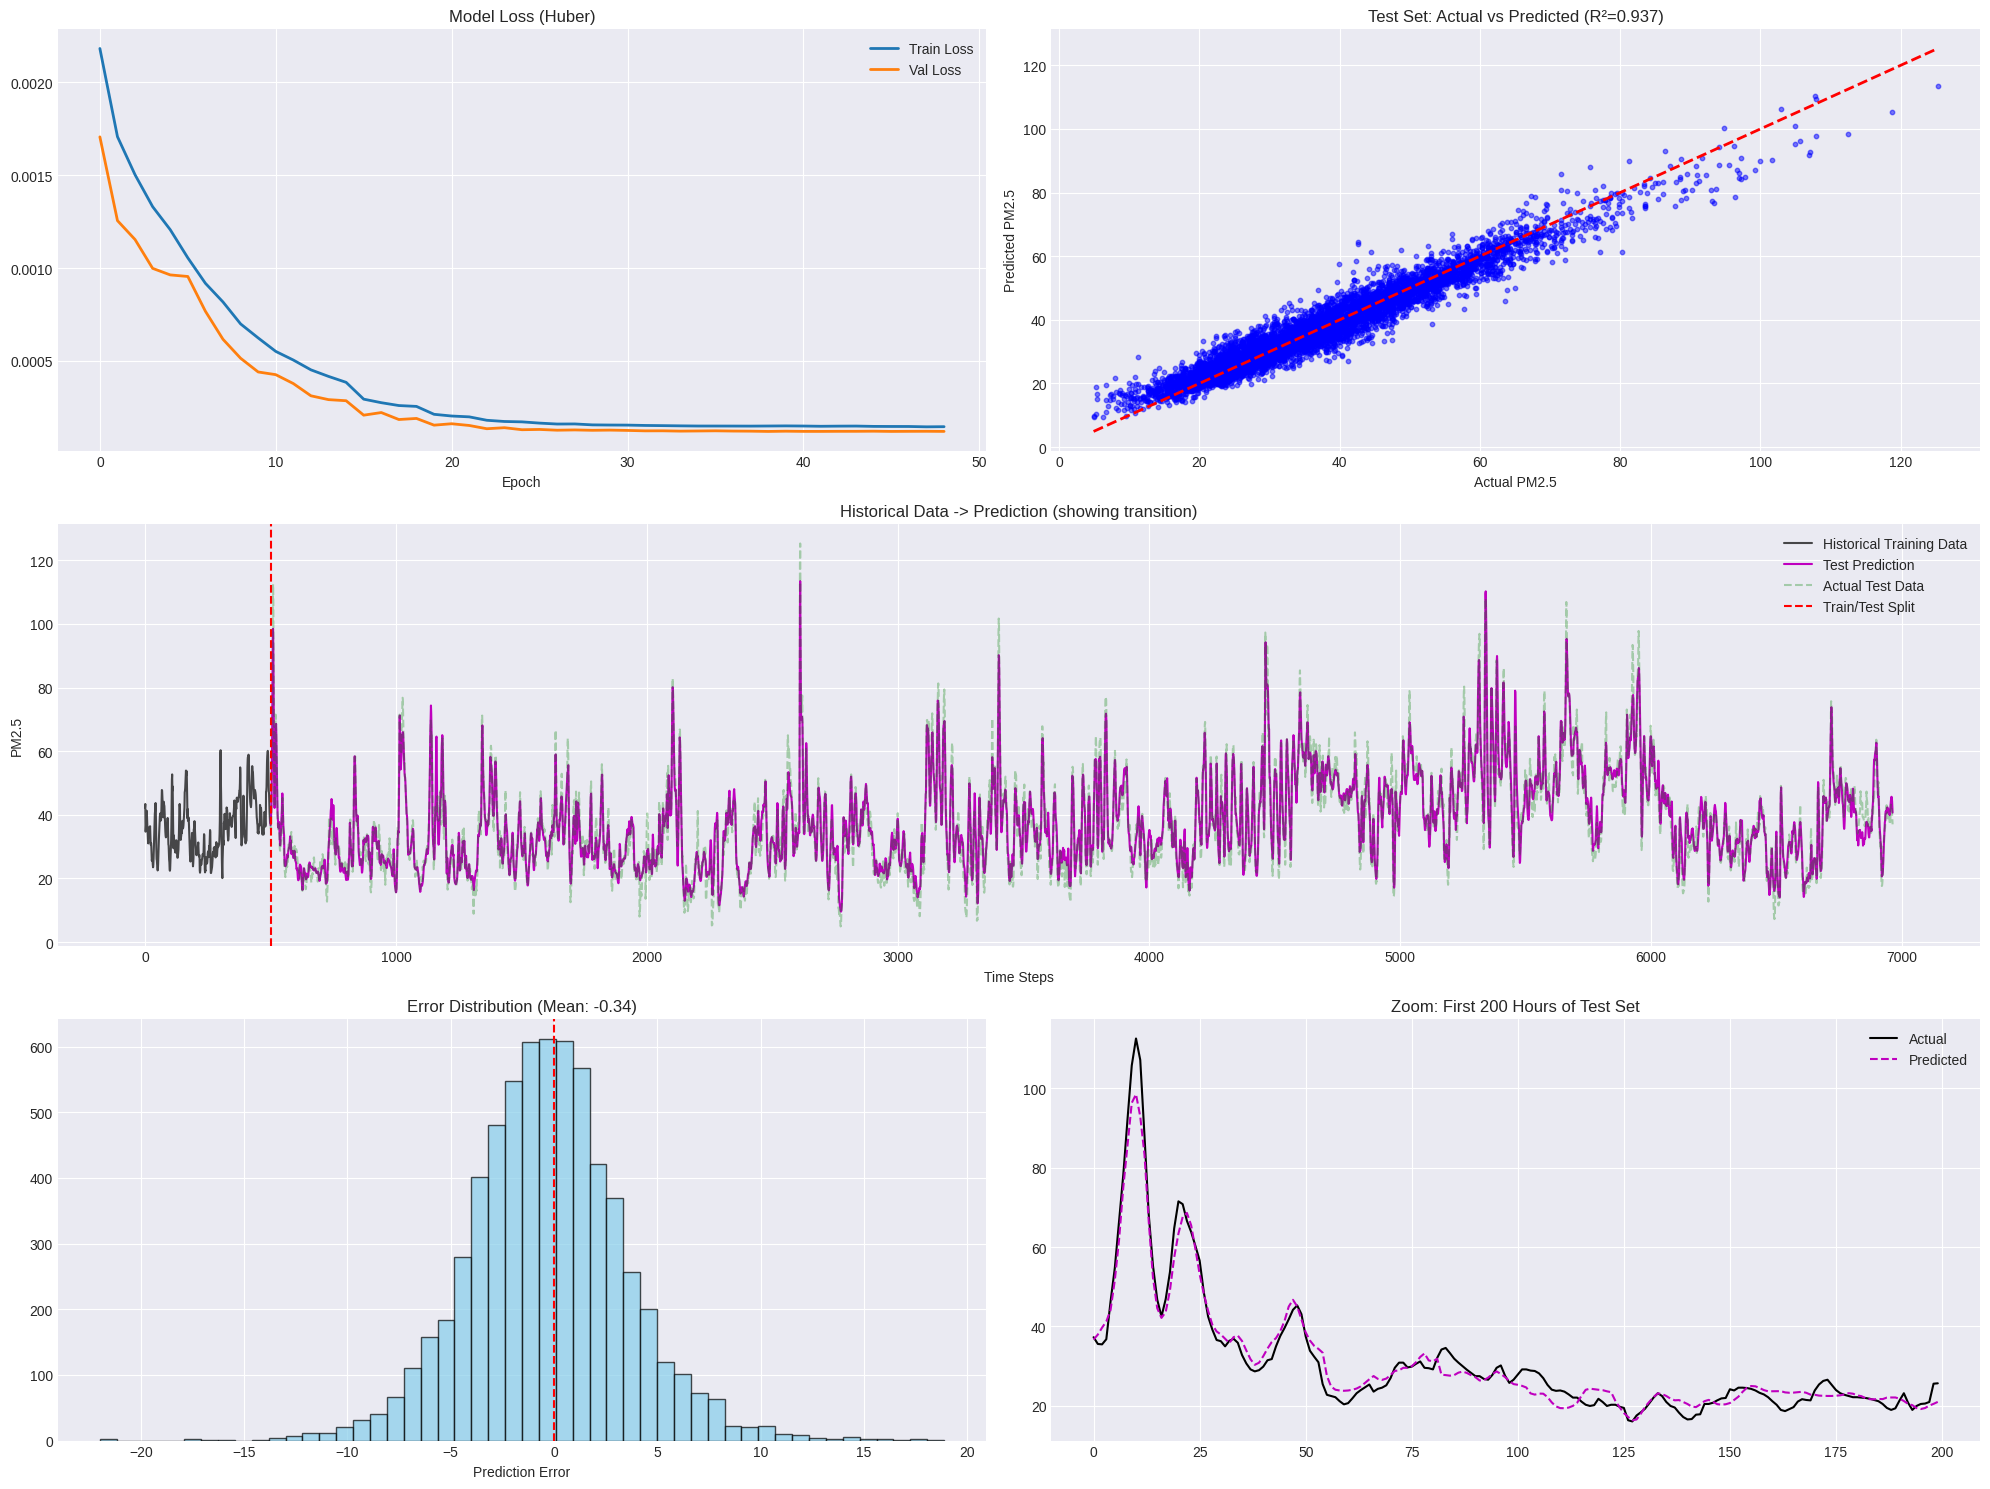

In [5]:
# 1. Predictions & Inverse Scaling
print("Generating predictions...")
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled = model.predict(X_test, verbose=0)

# Invert scaling to get real µg/m³ values
y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# 2. Metrics Calculation Function (Matches team format)
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # MAPE (Mean Absolute Percentage Error) - Regression version of "Accuracy"
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100

    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE: {mae:.2f} μg/m³")
    print(f"  RMSE: {rmse:.2f} μg/m³")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE (Inv Accuracy): {mape:.2f}%")

    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

print("-" * 50)
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test Set")
print("-" * 50)

# 3. TEAM-STYLE VISUALIZATION
fig = plt.figure(figsize=(20, 15))

# Plot 1: Training History
ax1 = plt.subplot(3, 2, 1)
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Model Loss (Huber)')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot 2: Scatter Plot (Actual vs Predicted)
ax2 = plt.subplot(3, 2, 2)
ax2.scatter(y_test_actual, y_test_pred, alpha=0.5, s=10, c='blue')
# Perfect prediction line
ax2.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2)
ax2.set_xlabel('Actual PM2.5')
ax2.set_ylabel('Predicted PM2.5')
ax2.set_title(f'Test Set: Actual vs Predicted (R²={test_metrics["r2"]:.3f})')

# Plot 3: Full Data View (End of Train + Test)
# This shows the transition from training data (black) to test predictions (magenta)
ax3 = plt.subplot(3, 1, 2) # Spans full width
display_len = 500  # Show last 500 hours of training + all testing
start_idx = len(y_train_actual) - (display_len)

# Create plotting arrays
train_plot_data = y_train_actual[-display_len:]
test_pred_data = y_test_pred

# X-axis indices
x_train = range(len(train_plot_data))
x_test = range(len(train_plot_data), len(train_plot_data) + len(test_pred_data))

ax3.plot(x_train, train_plot_data, 'k-', label='Historical Training Data', alpha=0.7)
ax3.plot(x_test, test_pred_data, 'm-', label='Test Prediction', linewidth=1.5)
# Also plot actual test data lightly to see accuracy
ax3.plot(x_test, y_test_actual, 'g--', label='Actual Test Data', alpha=0.3)

ax3.axvline(x=len(train_plot_data), color='r', linestyle='--', label='Train/Test Split')
ax3.set_title(f'Historical Data -> Prediction (showing transition)')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('PM2.5')
ax3.legend()

# Plot 4: Error Distribution
ax4 = plt.subplot(3, 2, 5)
errors = y_test_actual - y_test_pred
ax4.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=0, color='r', linestyle='--')
ax4.set_title(f'Error Distribution (Mean: {errors.mean():.2f})')
ax4.set_xlabel('Prediction Error')

# Plot 5: Zoomed in Test Forecast
ax5 = plt.subplot(3, 2, 6)
ax5.plot(y_test_actual[:200], 'k-', label='Actual')
ax5.plot(y_test_pred[:200], 'm--', label='Predicted')
ax5.set_title('Zoom: First 200 Hours of Test Set')
ax5.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'team_style_results.png'))
plt.show()

Generating 24-hour forecast for city_doha...
Last available data point: 2025-12-04 23:00:00
Forecast complete. From 2025-12-05 00:00:00 to 2025-12-05 23:00:00


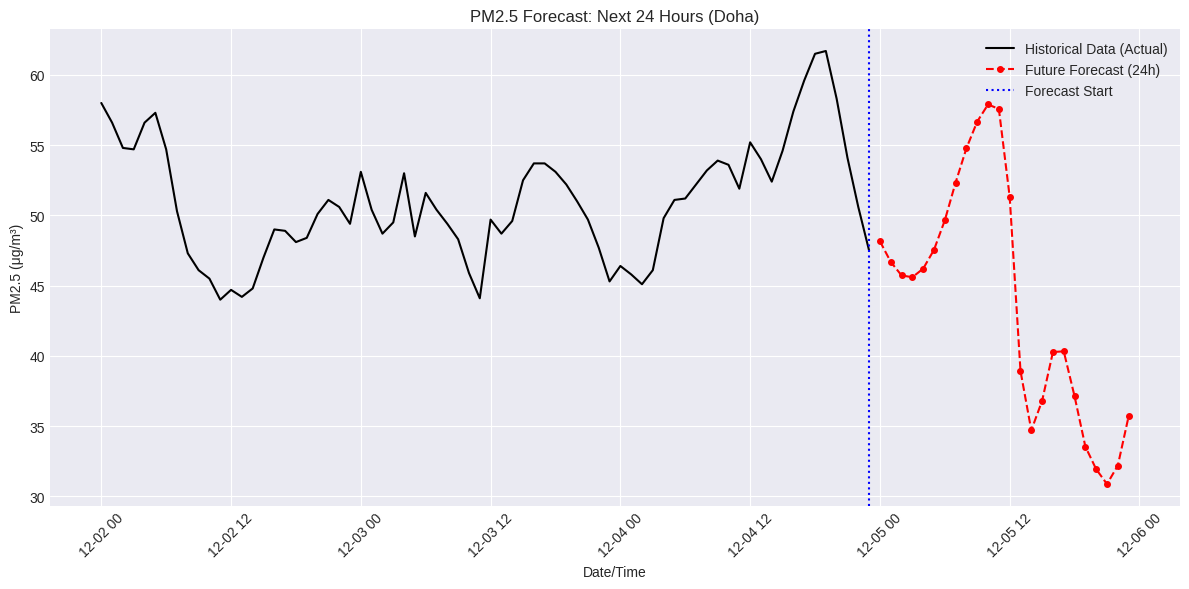


Forecasted Values:
                 Time  Predicted_PM2.5
0 2025-12-05 00:00:00        48.160286
1 2025-12-05 01:00:00        46.694229
2 2025-12-05 02:00:00        45.728447
3 2025-12-05 03:00:00        45.599052
4 2025-12-05 04:00:00        46.207821
5 2025-12-05 05:00:00        47.546124
6 2025-12-05 06:00:00        49.644245
7 2025-12-05 07:00:00        52.334988
8 2025-12-05 08:00:00        54.776054
9 2025-12-05 09:00:00        56.678024


In [6]:
from datetime import timedelta

# ==========================================
# CONFIGURATION FOR FORECAST
# ==========================================
FORECAST_HOURS = 24
TARGET_CITY_PREFIX = 'city_doha'  # Choose the city you want to forecast for
# ==========================================

print(f"Generating {FORECAST_HOURS}-hour forecast for {TARGET_CITY_PREFIX}...")

# 1. Get the very last sequence of data for the specific city
# We need to filter for the city to ensure time continuity
city_df = df_encoded[df_encoded[TARGET_CITY_PREFIX] == 1].copy()
last_sequence_df = city_df.iloc[-TIME_STEPS:]

# Get the last timestamp to start forecasting from
last_time = city_df['time'].iloc[-1]
print(f"Last available data point: {last_time}")

# Prepare the initial input sequence (scaled)
# We re-scale just this sequence to ensure it matches model expectations
last_sequence_scaled = scaler_X.transform(last_sequence_df[all_features])
current_batch = last_sequence_scaled.reshape((1, TIME_STEPS, len(all_features)))

# 2. Iterative Forecast Loop
future_predictions = []
future_dates = []

current_time = last_time

for i in range(FORECAST_HOURS):
    # A. Predict PM2.5 for the next hour
    pred_scaled = model.predict(current_batch, verbose=0)
    pred_value = scaler_y.inverse_transform(pred_scaled)[0][0]

    # Store prediction
    next_time = current_time + timedelta(hours=1)
    future_predictions.append(pred_value)
    future_dates.append(next_time)

    # B. Update Feature Vector for the next step
    # Since we don't have future weather, we assume 'Persistence' (copy last hour's weather)
    # BUT we MUST update the time features (hour_sin, hour_cos)

    # Copy the last row of features
    next_features = current_batch[0, -1, :].copy()

    # Update Time Features (indices depend on your all_features list order)
    # We know 'hour_sin' and 'hour_cos' are in all_features
    h_sin_idx = all_features.index('hour_sin')
    h_cos_idx = all_features.index('hour_cos')

    next_features[h_sin_idx] = np.sin(2 * np.pi * next_time.hour / 24)
    next_features[h_cos_idx] = np.cos(2 * np.pi * next_time.hour / 24)

    # Reshape and append to batch (sliding window)
    next_features = next_features.reshape(1, 1, len(all_features))
    current_batch = np.append(current_batch[:, 1:, :], next_features, axis=1)

    current_time = next_time

print(f"Forecast complete. From {future_dates[0]} to {future_dates[-1]}")

# 3. Visualization
plt.figure(figsize=(12, 6))

# Plot last 72 hours of actual data
history_hours = 72
history_dates = city_df['time'].iloc[-history_hours:]
history_values = scaler_y.inverse_transform(
    scaler_y.transform(city_df[[target_col]].iloc[-history_hours:])
)

plt.plot(history_dates, history_values, label='Historical Data (Actual)', color='black', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Forecast (24h)', color='red', marker='o', markersize=4, linestyle='--')

# Formatting
plt.axvline(x=last_time, color='blue', linestyle=':', label='Forecast Start')
plt.title(f'PM2.5 Forecast: Next 24 Hours ({TARGET_CITY_PREFIX.replace("city_", "").capitalize()})')
plt.xlabel('Date/Time')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Print Numerical Forecast
print("\nForecasted Values:")
forecast_df = pd.DataFrame({'Time': future_dates, 'Predicted_PM2.5': future_predictions})
print(forecast_df.head(10)) # Show first 10 rows